In [1]:
import pandas as pd
import matplotlib.pylab as plt
import numpy as np

from scipy.signal import find_peaks
from scipy.signal import butter, lfilter

import mafaulda as src
import feature_discovery as fdiscovery

file_list = [
    'raw_data/air_conditioning/excool_digitalis/high_pressure_pump_40percent__1.tsv',
    'raw_data/air_conditioning/excool_digitalis/high_pressure_pump_40percent__2.tsv',
    'raw_data/air_conditioning/excool_digitalis/high_pressure_pump_40percent_speed_up__3.tsv',
    'raw_data/air_conditioning/excool_digitalis/high_pressure_pump_80percent__4.tsv',
    'raw_data/air_conditioning/shc2/compressor_shc2_klima4_bad.tsv',
    'raw_data/air_conditioning/shc2/compressor_shc2_klima5_good.tsv',
    'raw_data/air_conditioning/vertiv_digitalis/compressor_top_1.tsv',
    'raw_data/air_conditioning/vertiv_digitalis/compressor_top_2.tsv',
    'raw_data/air_conditioning/vertiv_digitalis/compressor_top_3.tsv',
    'raw_data/air_conditioning/vertiv_digitalis/compressor_base.tsv',
    'raw_data/air_conditioning/vertiv_digitalis/compressor_side.tsv'
]
src_file = file_list[4]

kind = 'beaglebone' # beaglebone, beaglebone_w_timer, boat

T_WAVEFORM = 5
T_SEC = T_WAVEFORM
NFFT = 512

if kind == 'beaglebone':
    # Fan
    Fs = 1160 # 1160 Hz +/-150 Hz (1020 - 1340 Hz)
    # src_file = 'raw_data/fan_test/fan_speed_3_4000.tsv'
    ts = pd.read_csv(src_file, delimiter='\t', index_col=False, header=None, names=['x', 'y', 'z'])
    # Calculate amplitude in m/s^2 Beaglebone Black ADC and ADXL335 resolution (VIN 1.8V, 12bits)
    for dim in ts.columns:
        ts[dim] = ts[dim] * (1800 / 4096)  # ADC to mV
        ts[dim] = (ts[dim] / 180) * 9.81  # mV to m/s^2 (180 mV/g)
        ts[dim] -= ts[dim].mean()

    ts['t'] = ts.index * (1 / Fs)

elif kind == 'beaglebone_w_timer':
    # Fan
    Fs = 1160 # 1160 Hz +/-150 Hz (1020 - 1340 Hz)
    # src_file = 'raw_data/fan_test/fan_speed_3_4000.tsv'
    ts = pd.read_csv(src_file, delimiter='\t', index_col=False, header=None, names=['x', 'y', 'z', 'diff'])
    ts = ts.iloc[1:,:]
    
    # Calculate amplitude in m/s^2 Beaglebone Black ADC and ADXL335 resolution (VIN 1.8V, 12bits)
    for dim in ts.columns:
        ts[dim] = ts[dim] * (1800 / 4096)  # ADC to mV
        ts[dim] = (ts[dim] / 180) * 9.81  # mV to m/s^2 (180 mV/g)
        ts[dim] -= ts[dim].mean()

    ts['t'] = t['diff'].cumsum()
    Fs = ts['t'].mean()

elif kind == 'boat':
    # Boat
    Fs = 200
    #src_file = 'boat/Boat__2.txt'
    ts = pd.read_csv(src_file, delimiter=' ')
    ts['t'] = ts['t'].cumsum()
    for dim in ts.columns:
        ts[dim] -= ts[dim].mean()

ts.set_index('t', inplace=True)
ts

,x,y,z
t,,,
0.000000,-0.036499,-0.004614,-0.028153
0.000862,-0.036499,0.019336,-0.195804
0.001724,-0.060450,-0.028565,-0.171854
0.002586,-0.060450,-0.004614,-0.123954
0.003448,-0.060450,-0.052515,-0.052103
...,...,...,...
39.827586,0.035351,-0.172266,0.019747
39.828448,0.131152,-0.028565,0.187399
39.829310,0.011401,-0.076465,0.307150


In [2]:
ts.describe()

,x,y,z
count,4.620500e+04,4.620500e+04,4.620500e+04
mean,2.343615e-16,-2.879232e-15,8.442549e-15
std,8.390486e-02,7.526219e-02,1.902907e-01
min,-3.957523e-01,-4.596680e-01,-1.177762e+00
25%,-6.044956e-02,-2.856451e-02,-1.239537e-01
50%,-1.254917e-02,-4.614320e-03,-4.202753e-03
75%,5.930142e-02,4.328607e-02,1.155482e-01
max,3.946042e-01,4.504394e-01,1.097506e+00


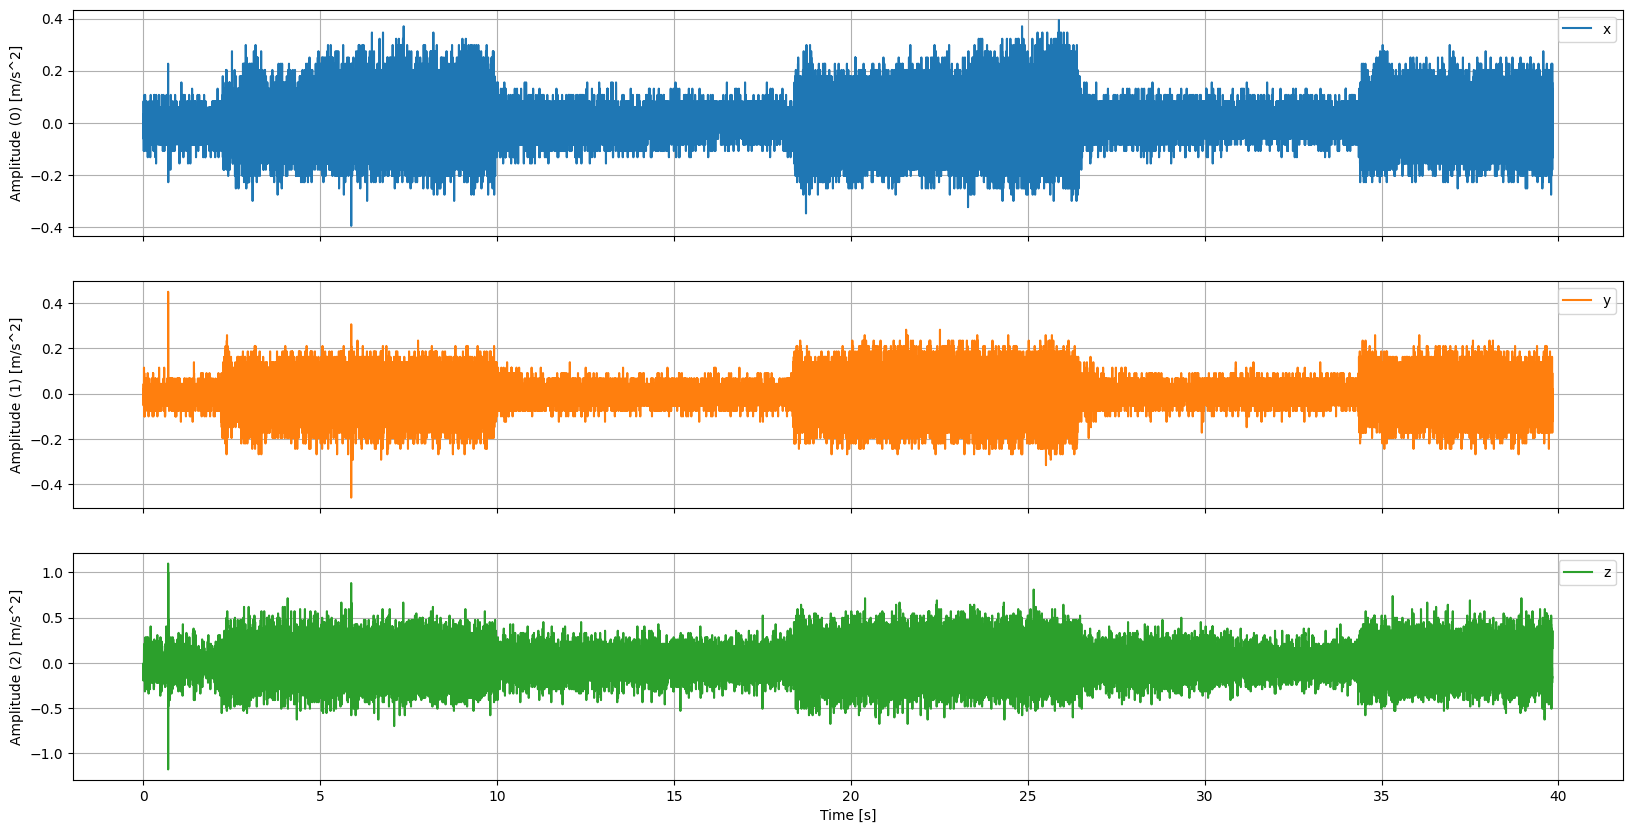

In [3]:
ax = ts[['x', 'y', 'z']].plot(figsize=(20, 10), grid=True, subplots=True)
for i in range(3):
    ax[i].set_xlabel('Time [s]')
    ax[i].set_ylabel(f'Amplitude ({i}) [m/s^2]')
plt.savefig('waveform.png')

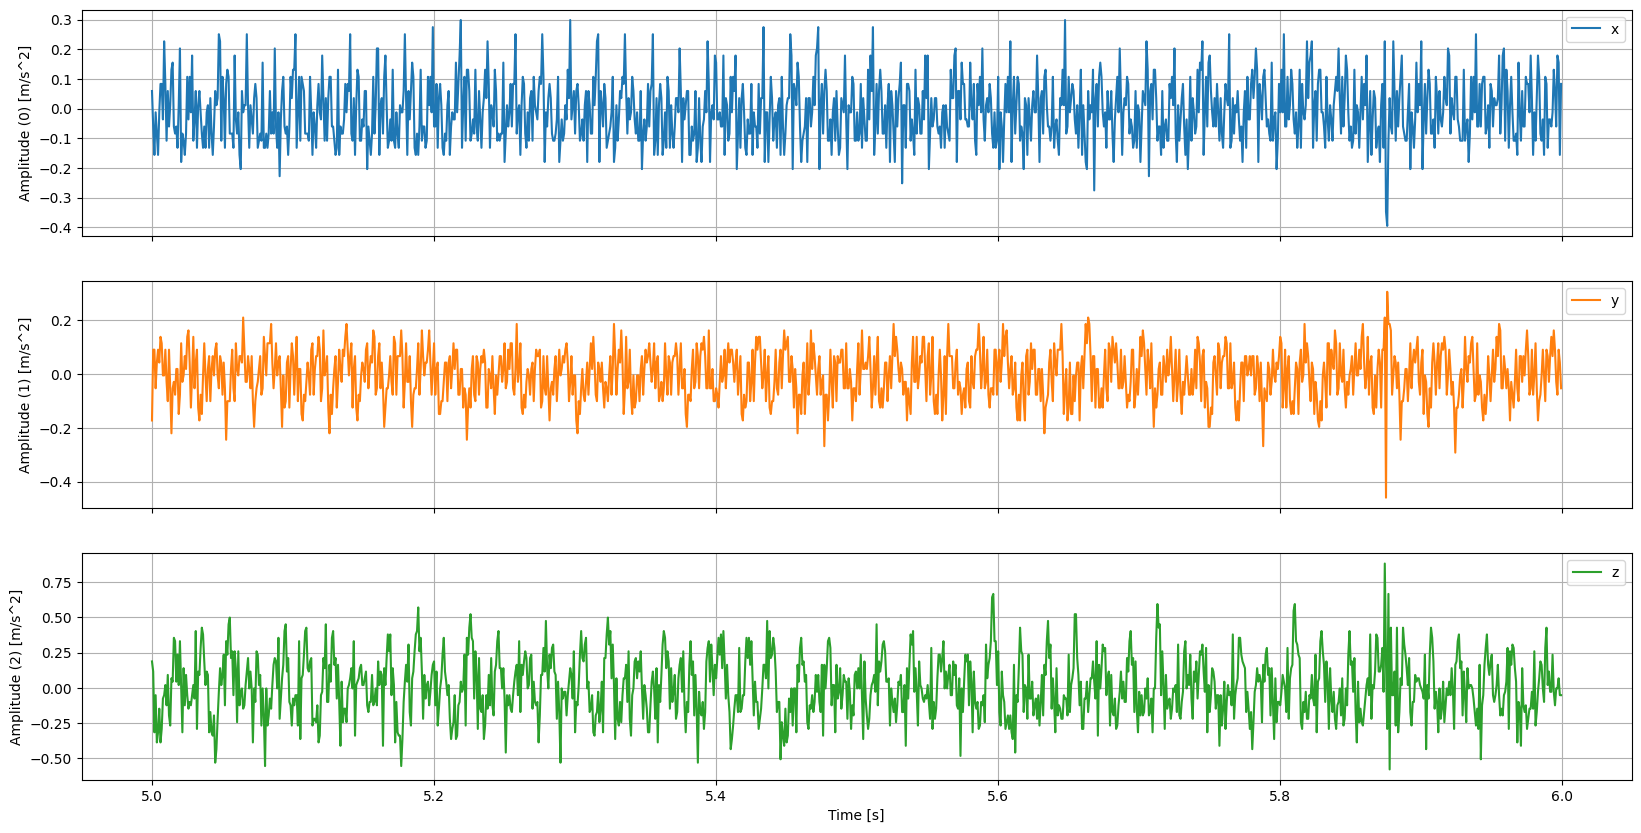

In [4]:
ax = ts[['x', 'y', 'z']].iloc[int(T_WAVEFORM*Fs):int(T_WAVEFORM*Fs)+Fs].plot(figsize=(20, 10), grid=True, subplots=True)
for i in range(3):
    ax[i].set_xlabel('Time [s]')
    ax[i].set_ylabel(f'Amplitude ({i}) [m/s^2]')
plt.savefig('waveform_zoom.png')

In [5]:
def spectogram(x):
    plt.figure(figsize=(20, 4))
    Pxx, freqs, t, im = plt.specgram(x, NFFT=NFFT, Fs=Fs, mode='magnitude', scale='dB')
    plt.xlabel('Time [s]')
    plt.ylabel('Frequency [Hz]')
    src.resolution_calc(Fs, NFFT)
    return freqs, Pxx


def spectrum_slice(Pxx, t):
    fig, ax = plt.subplots(2, 1, figsize=(20, 8))
    n = (Fs * t) // NFFT + 1

    dB = 20 * np.log10(Pxx.T[n] / 0.000001)
    ax[0].plot(freqs, dB)      # 1 dB = 1 um/s^2
    ax[0].grid(True)
    ax[0].set_xlabel('Frequency [Hz]')
    ax[0].set_ylabel('Amplitude [dB]')
    
    ax[1].plot(freqs, Pxx.T[n])
    ax[1].grid(True)
    ax[1].set_xlabel('Frequency [Hz]')
    ax[1].set_ylabel('Amplitude [m/s^2]')
    return n


def get_max_frequency(freqs, Pxx, i):
    max_freq = freqs[np.argmax(Pxx.T[i])]
    print(f'Fundamental: {max_freq} Hz')
    return max_freq


def get_peaks(freqs, Pxx, i, top=5):
    amplitudes = Pxx.T[i]
    peaks, _ = find_peaks(amplitudes, distance=3)

    fundamental = get_max_frequency(freqs, Pxx, i)
    f_top = freqs[peaks[np.argsort(amplitudes[peaks])]][::-top]
    y_top = np.sort(amplitudes[peaks])[::-top]

    return pd.DataFrame({
        'f': f_top,
        'y': y_top,
        '1x': f_top / fundamental 
    })


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter(order, [lowcut, highcut], fs=fs, btype='band')
    y = lfilter(b, a, data)
    return y

Window size: 512
Heinsenberg box
	Time step: 441.37931034482756 ms
	Frequency step: 2.265625 Hz


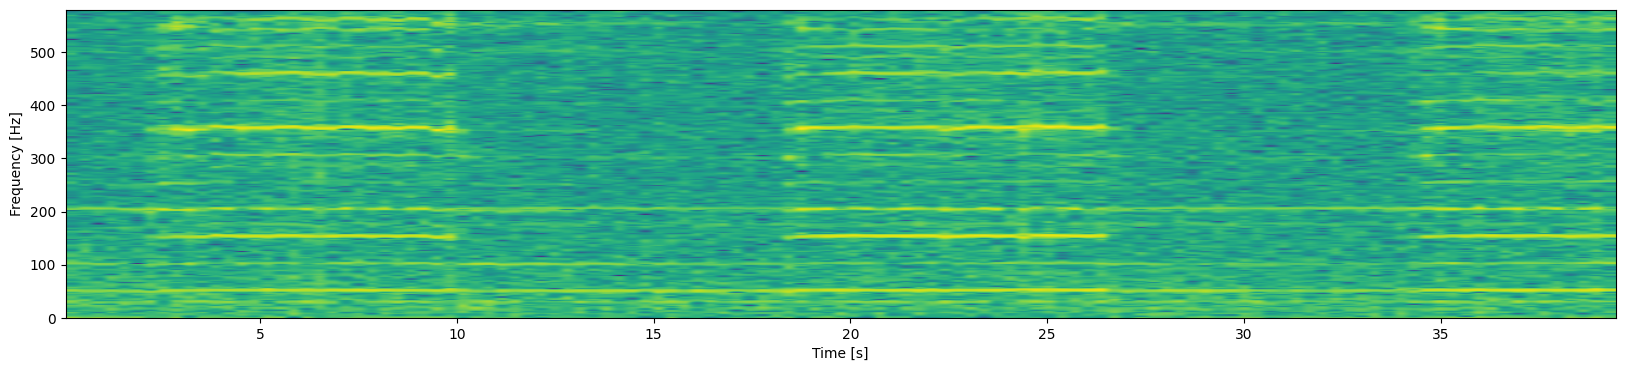

In [6]:
freqs, Pxx = spectogram(ts['x'])
plt.savefig(f'x_axis_fft_{NFFT}.png')

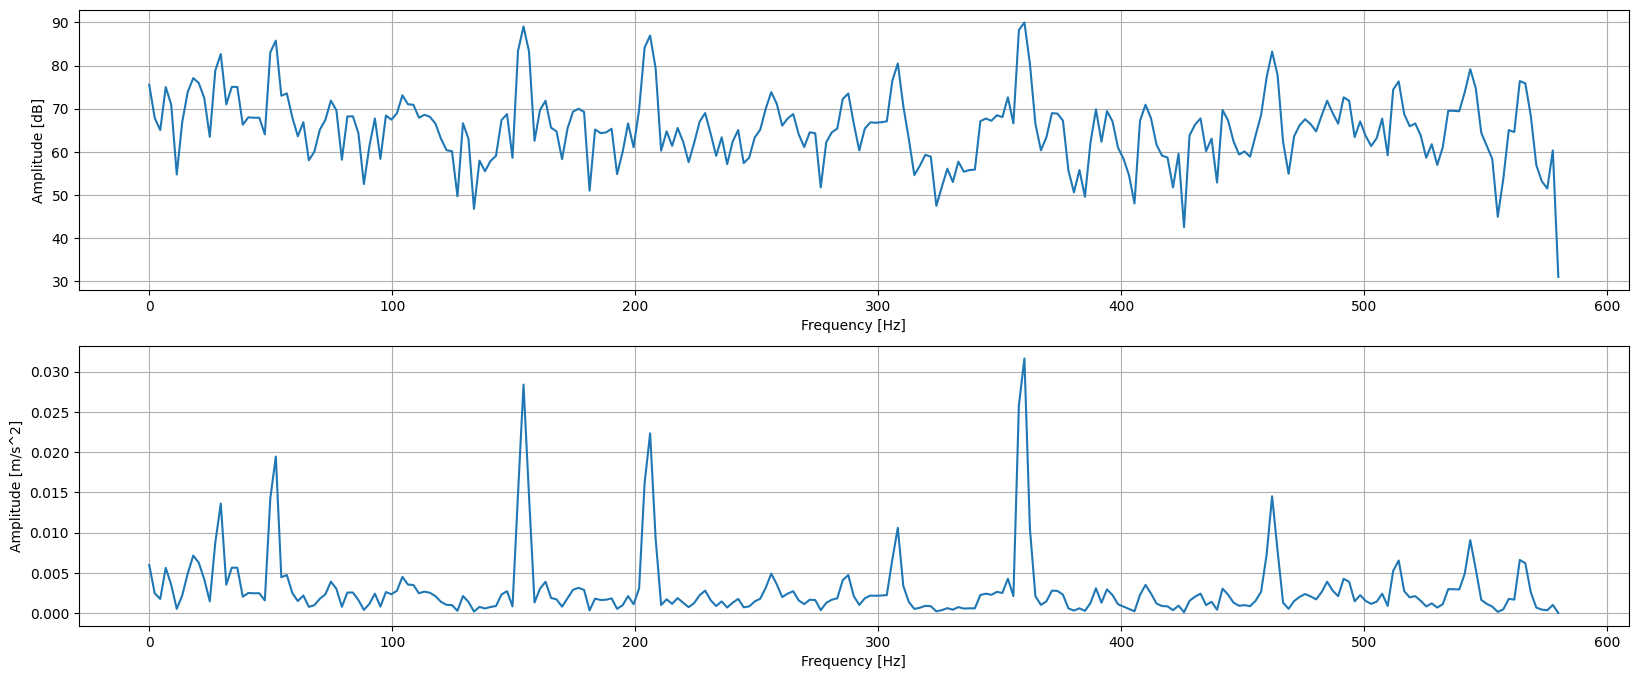

In [7]:
i_window = spectrum_slice(Pxx, T_SEC);
plt.savefig(f'x_axis_fft_{NFFT}_at_{T_SEC}s.png')

In [9]:
fdiscovery.harmonic_product_spectrum(freqs, Pxx.T[i_window])

(159, 360.234375)

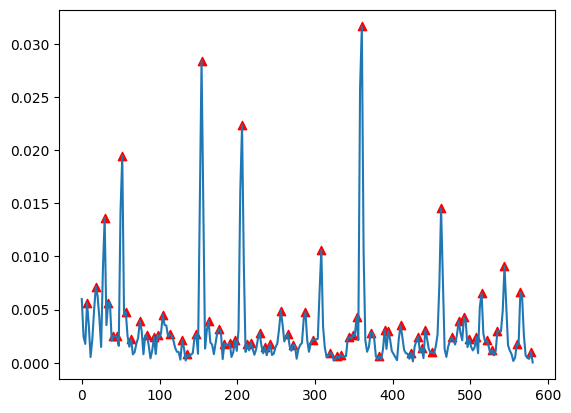

In [10]:
peaks = fdiscovery.mms_peak_finder(Pxx.T[i_window])
plt.plot(freqs, Pxx.T[i_window])
plt.scatter(freqs[peaks], Pxx.T[i_window][peaks], marker='^', color='red')
plt.show()

[(6.796875, 0.00563576925657112), (18.125, 0.007159210750156569), (29.453125, 0.013615244299302581), (33.984375, 0.005657713213557347), (83.828125, 0.0025788796539475416), (287.734375, 0.004743511512114618)]

[(18.125, 0.007159210750156569), (33.984375, 0.005657713213557347), (52.109375, 0.019447471964125128), (74.765625, 0.00392620526474228), (147.265625, 0.0027392614045720124), (197.109375, 0.002134657880872499), (287.734375, 0.004743511512114618)]

[(29.453125, 0.013615244299302581), (56.640625, 0.004751642565485452), (83.828125, 0.0025788796539475416), (113.28125, 0.0026889305823283613), (147.265625, 0.0027392614045720124), (319.453125, 0.0009248125575957464)]

[(33.984375, 0.005657713213557347), (63.4375, 0.002206596541821308), (97.421875, 0.0026362341069046643), (129.140625, 0.002143578905941971), (163.125, 0.003912414935995867), (197.109375, 0.002134657880872499), (296.796875, 0.002194264865767086), (527.890625, 0.0012258734439761297)]

[(40.78125, 0.0025126407944243883), (163.1

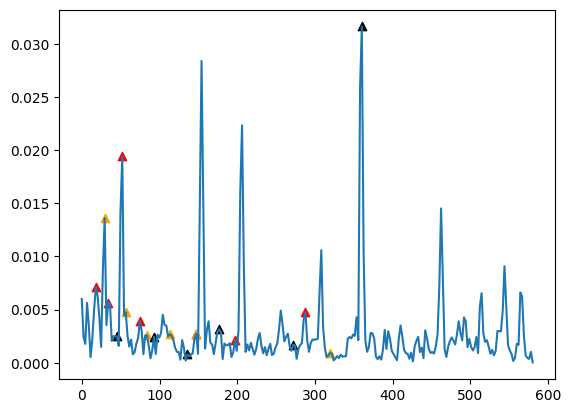

In [11]:
h_series = fdiscovery.harmonic_series_detection(freqs, Pxx.T[i_window], Fs, NFFT)
plt.plot(freqs, Pxx.T[i_window])
s = h_series[1]
plt.scatter([x[0] for x in s], [x[1] for x in s], marker='^', color='red')
s = h_series[2]
plt.scatter([x[0] for x in s], [x[1] for x in s], marker='^', color='orange')
s = h_series[5]
plt.scatter([x[0] for x in s], [x[1] for x in s], marker='^', color='black')

In [12]:
x_fundamental = get_max_frequency(freqs, Pxx, i_window)

Fundamental: 360.234375 Hz


In [13]:
get_peaks(freqs, Pxx, i_window)

Fundamental: 360.234375 Hz


,f,y,1x
0,360.234375,0.031623,1.000000
1,29.453125,0.013615,0.081761
2,514.296875,0.006550,1.427673
3,353.437500,0.004287,0.981132
4,410.078125,0.003518,1.138365
5,228.828125,0.002815,0.635220
6,97.421875,0.002636,0.270440
7,507.500000,0.002427,1.408805
8,129.140625,0.002144,0.358491
9,183.515625,0.001815,0.509434


In [ ]:
freqs, Pxx = spectogram(ts['y'])
plt.savefig(f'y_axis_fft_{NFFT}.png')

In [ ]:
i_window = spectrum_slice(Pxx, T_SEC);
plt.savefig(f'y_axis_fft_{NFFT}_at_{T_SEC}s.png')

In [ ]:
y_fundamental = get_max_frequency(freqs, Pxx, i_window)

In [ ]:
get_peaks(freqs, Pxx, i_window)

In [ ]:
freqs, Pxx = spectogram(ts['y'])
plt.savefig(f'z_axis_fft_{NFFT}.png')

In [ ]:
i_window = spectrum_slice(Pxx, T_SEC);
plt.savefig(f'z_axis_fft_{NFFT}_at_{T_SEC}s.png')

In [ ]:
z_fundamental = get_max_frequency(freqs, Pxx, i_window)

In [ ]:
get_peaks(freqs, Pxx, i_window)

In [ ]:
ts[['x', 'y', 'z']].hist(figsize=(20, 5), grid=True, bins=50)

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(20, 4))

for i, col in enumerate([('x', 'y'), ('x', 'z'), ('y', 'z')]):
    ax[i].scatter(ts[col[0]], ts[col[1]], s=1)
    ax[i].grid(True)
    ax[i].set_xlabel(col[0].upper())
    ax[i].set_ylabel(col[1].upper())
    ax[i].grid(True)

plt.savefig('orbitals.png')

In [ ]:
space = 5
ts['x_1x'] = butter_bandpass_filter(ts['x'], x_fundamental - space, x_fundamental + space, Fs)
ts['y_1x'] = butter_bandpass_filter(ts['y'], y_fundamental - space, y_fundamental + space, Fs)
ts['z_1x'] = butter_bandpass_filter(ts['z'], z_fundamental - space, z_fundamental + space, Fs)

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(20, 4))

for i, col in enumerate([('x_1x', 'y_1x'), ('x_1x', 'z_1x'), ('y_1x', 'z_1x')]):
    ax[i].scatter(ts[col[0]], ts[col[1]], s=1)
    ax[i].grid(True)
    ax[i].set_xlabel(col[0].upper())
    ax[i].set_ylabel(col[1].upper())
    ax[i].grid(True)

plt.savefig('orbitals_1x.png')